# Paddy disease classification
Kaggle competition
https://www.kaggle.com/competitions/paddy-disease-classification

### Setting up env and downloading data from kaggle

In [78]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Running in Colab...
...Installed required dependencies


In [79]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sucesfully set kaggle credentials


In [80]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('paddy-disease-classification')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
sample_submission.csv  test_images  train.csv  train_images


### Inspecting the data

In [81]:
from fastai.vision.all import *
set_seed(42)

train_path = path/'train_images'
files = get_image_files(train_path)

In [82]:
#Simply contains the filename of all the images in the given folder
files[0:3]

(#3) [Path('paddy-disease-classification/train_images/brown_spot/104426.jpg'),Path('paddy-disease-classification/train_images/brown_spot/102296.jpg'),Path('paddy-disease-classification/train_images/brown_spot/100854.jpg')]

### WARNING! Image size: 480x640 or 640x480 ??
Images need to be resized to same dimension for the ML model to process.


**OBS for dimensions!!** If you request different library you might get different response.
- In "image world" (PIL), Columns by Rows (if using img.size, .shape will return rows by columns)
- Pytorch, returns Rows by Columns

Size according to PIL image: (480, 640)
Shape according to PIL image: (640, 480)
Shape according to torch, tensor: torch.Size([640, 480, 3])


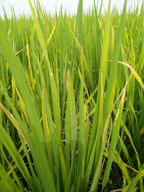

In [83]:
img = PILImage.create(files[5])
print(f'Size according to PIL image: {img.size}')
print(f'Shape according to PIL image: {img.shape}')
#Convert to tensor
img_t = tensor(img)
print(f'Shape according to torch, tensor: {img_t.shape}')
img.to_thumb(192)

Checking the image size is suprisingly slow process, hence we do it in parallel to speed up.

In [92]:
import multiprocessing

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

Number of cores 2


In [85]:
from fastcore.parallel import *

def check_size(img):
    return PILImage.create(img).size

sizes = parallel(check_size, files, n_workers=n_cores)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

Observing that a few are out of size, hence we have to resize our images.

**Resizing: You want to do the remainder on a GPU**
- Colab runtime: 6 seconds
- Local CPU runtime: 1 min 20 seconds (256 bs vs default 64 did not improve anything, quite the contrary)

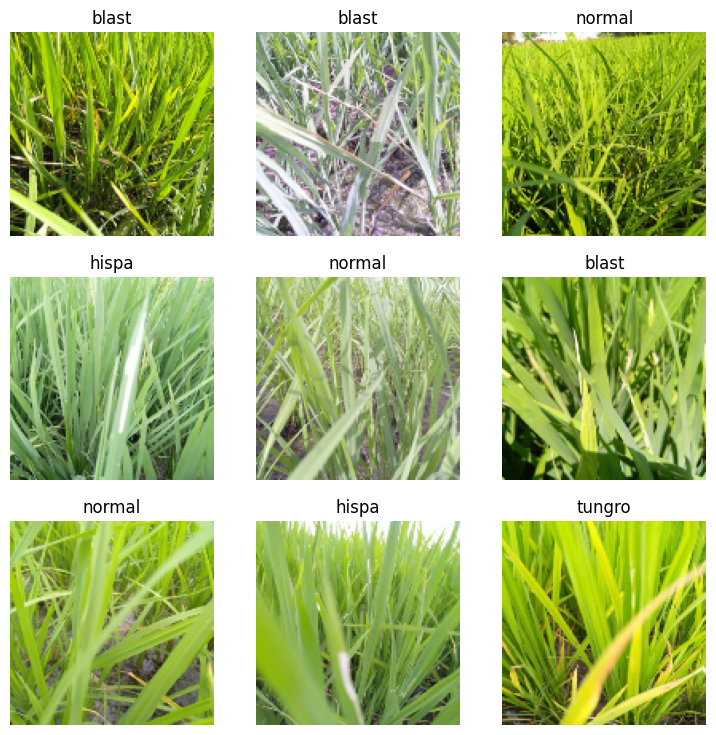

In [101]:
dls = ImageDataLoaders.from_folder(train_path,
                                        valid_pct=0.2,
                                        seed=42,
                                        item_tfms=Resize(480, method='squish'),
                                        #Data augmentation done on GPU, transformations of the data taking
                                        #a subset of the image (128) and applying random transformations
                                        batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch()

### The first model
Best models for finetuning, 100 different models, evaluated on the Pets dataset and a sattelite imagedataset (Planet): https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning . **One year old**

To begin with, choose decent accuracy but FAST model = Resnet26d


In [90]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Find LR timing:
- Colab: 1 min
- Local CPU: 3 min 46 sec

SuggestedLRs(valley=0.0010000000474974513, slide=0.00363078061491251)

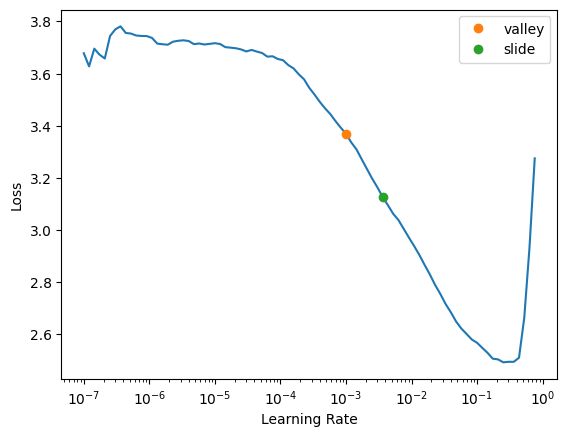

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

Generally speaking the reccomendations from fastAI is conservative to be on the safe side, so typically one can select a higher LR to speed up the process, as long as one is not too close at the party where LR is too high and we end up overstepping.

In [102]:
#3 epochs, LR= 10^-2
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.754902,0.934162,0.274387,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.638068,0.524005,0.159058,00:39
1,0.450527,0.345563,0.105718,00:45
2,0.326066,0.335255,0.101394,00:52


Took 8 min to finetune on colab, quite a bit longer than the 1 min it took in Jeremys tutorial.

## Saving the model
https://docs.fast.ai/learner.html#learner

### Using .save

with_opt saves the final state of the optimizer (hyperparamters like lr, and what is being optimized).with_opt is needed if further training is needed, not for inference

Note to self: it does NOT store the initial training hyperparamters like lr = 0.01

(Nevertheless potentially nice for reproducability if loading in a seperate script).

In [43]:
learn.save("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models/paddy_1", with_opt=True)

Path('/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models/paddy_1.pth')

In [17]:
#For prettier doc prints
pip install nbdev -q

In [22]:
doc(Learner.save)

**Learner.save saves only the model weights.**

On load we will need to recreate the Learner and dataloaders so the model inputs during prediction are the same as they would be during the validation step when we were training the model.

### Using .export
https://benjaminwarner.dev/2021/10/01/inference-with-fastai

Export pickles the entire learner object. Including the dataloaders, loss function, optimizer, augmentations or transforms, and all callbacks. All of these are loaded and restored when calling load_learner

In [42]:
doc(Learner.export)

In [44]:
learn.export("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models/paddy_1.pkl")

## Loading the model

### Using .load



In [87]:
dls_loaded = ImageDataLoaders.from_folder(train_path,
                                        valid_pct=0.2,
                                        seed=42,
                                        item_tfms=Resize(480, method='squish'),
                                        #Data augmentation done on GPU, transformations of the data taking
                                        #a subset of the image (128) and applying random transformations
                                        batch_tfms=aug_transforms(size=128, min_scale=0.75))


In [48]:
#Redefines the learner
learn_loaded = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

#Loads the trained model weights
learn_loaded.load("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models/paddy_1", with_opt=True)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b3e8e54b-04f3-4f9b-8008-91718d00a427)')' thrown while requesting HEAD https://huggingface.co/timm/resnet26d.bt_in1k/resolve/main/model.safetensors


In [47]:
print(learn_loaded.opt.hypers)

[{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 2.155348388515352e-09, 'mom': 0.9499966892701156, 'eps': 1e-05}, {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 2.155348388516165e-07, 'mom': 0.9499966892701156, 'eps': 1e-05}]


In [49]:
learn_loaded.summary()

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 64 x 64   
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                          

In [54]:
learn_loaded.predict(files[0])

('brown_spot',
 tensor(4),
 tensor([2.1755e-03, 2.5130e-05, 1.5632e-06, 5.3313e-04, 9.9064e-01, 6.1732e-03,
         1.2175e-04, 7.6046e-06, 8.6483e-08, 3.2685e-04]))

### Using .load_learner
**Note** By default, load_learner will load to CPU. **Usually OK for inference!** - but if you are going to predict in batches, then you probably want to set cpu=False to load to the original device, or load to CPU then manually transfer to the new device.

**While load_learner restores the dataloader and all its settings, the loaded dataloader will not point to any data**


---



**Warning from FastAI docs** load_learner requires all your custom code be in the exact same place as when exporting your Learner (the main script, or the module you imported it from).

In [88]:
learn_loaded_2 = load_learner("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models/paddy_1.pkl")

In [89]:
learn_loaded_2.predict(files[0])

('brown_spot',
 tensor(4),
 tensor([2.2114e-03, 2.5768e-05, 1.6168e-06, 5.3261e-04, 9.9046e-01, 6.3048e-03,
         1.2296e-04, 7.7648e-06, 8.8431e-08, 3.3046e-04]))

In [56]:
#Optional if the learner should be transfered to GPU for inference/(further training?)
#learn_loaded_2.dls.to(device='cuda')
#learn_loaded_2.model.to(device='cuda')

# Predict on the test set
First we inspect the expected submission format for the kaggle competition.

In [58]:
ss = pd.read_csv(path/'sample_submission.csv')
ss.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


To make predictions on the test dataset we want to make sure we apply the same dataloader as during training, but on a new test set.  

We do so by using the "test_dl" function of fastAI to create a dataloder specifically for inference. Unlike the regular dataloader, this does not expect an input label on the data.

In [65]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

#If using the loaded model, grab the dls from the loaded learner:
#tst_dl = learn_loaded_2.dls.test_dl(tst_files)

In [62]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
#Numbers from 0 to 9 on the different 10 diseases
idxs

tensor([7, 8, 7,  ..., 8, 1, 5])

The actual names are automatically stored in the dls.vocab, and the competition submission expects names rather than integers.

In [67]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [72]:
#Using pandas to map (inefficient way to do it...)
mapping = dict(enumerate(dls.vocab))
print(f'Dict for mapping int to disease {mapping}')

#pandas.map, looks up each idxs in the pd in the mapping dict
result = pd.Series(idxs.numpy(), name='idxs').map(mapping)
result

Dict for mapping int to disease {0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [74]:
ss['label'] = result
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,bacterial_leaf_blight
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


## Submitting to kaggle via API

In [77]:
from kaggle import api
api.competition_submit_cli('subm.csv','first rn26d 128px', 'paddy-disease-classification')

100%|██████████| 69.9k/69.9k [00:02<00:00, 27.1kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification

# Speeding up training
Turns out the training time is so slow, due to limited CPU power that is used to load in the images.

**Rule of thumb: 8 CPUs pr. GPU** In this case we only have 2 CPU cores that ends up being the bottleneck for our train loop.


In [ ]:
#To clear cache
#torch.cuda.empty_cache()

In [122]:
import multiprocessing

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

Number of cores 2


Simplest solution is simply to resize images prior loading into the model to half height and width, reducing number of pixels by 4 and therefore also loading times by 4, and then to reduce the resize operation in the DLS to 192 instead of 480.

In [95]:
small_train_path = Path(path/'small_train_images')
resize_images(path/'train_images', dest=small_train_path, max_size=256, recurse=True)


Now we want to experiment with a few different architectures and image processing approaches (item and batch transforms). In order to make this easier, we'll put our modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

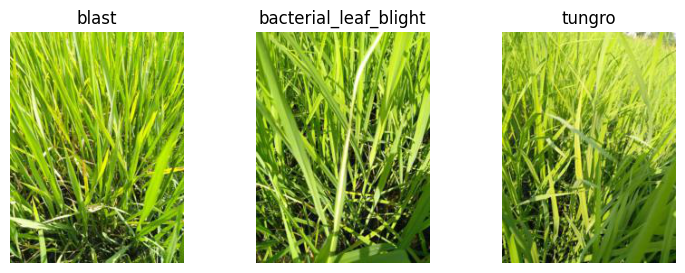

In [125]:
dls = ImageDataLoaders.from_folder(small_train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In [126]:
def train(arch, item, batch, epochs=5):
  dls = ImageDataLoaders.from_folder(small_train_path, valid_pct=0.2, seed=42, item_tfms=item, batch_tfms=batch)
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  learn.fine_tune(epochs,0.01)
  return learn

In [ ]:
learn = train('resnet26d', item=Resize(192, method='squish'),batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,3.146919,2.304427,0.777030,00:38


epoch,train_loss,valid_loss,error_rate,time


In [115]:
learn = train('resnet26d', item=Resize(192, method='squish'),batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,3.164094,2.300977,0.770783,00:40


epoch,train_loss,valid_loss,error_rate,time
0,2.666037,2.198867,0.747237,00:40
1,2.383075,2.026937,0.702547,00:40
2,2.215053,1.934409,0.668429,00:40
3,2.122086,1.926287,0.656896,00:39
4,2.100628,1.921772,0.658818,00:38


#Changing model
## A ConvNeXt model
 The GPU usage bar in colab is still fairly empty, so we're still CPU bound. That means we should be able to use a more capable model with little if any speed impact. Let's look again at the options in The best vision models for fine-tuning. convnext_small tops the performance/accuracy tradeoff score there, so let's give it a go!

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.310159,0.870774,0.262854,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.649732,0.491717,0.150408,00:50
1,0.524408,0.338067,0.111004,00:50
2,0.328758,0.240409,0.077367,00:50
3,0.189834,0.150118,0.043729,00:54
4,0.131829,0.155641,0.048534,00:51


In [ ]:
arch = 'convnext_small_in22k'
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

# Preprocessing experiments
## Resizing & data augmentation
- Cropping: Removes information
- Squishing: Distorts the data
- Padding: Only option that retains all information without distorting, but waste pixels (zero value pixels)

Let's try to change data augmentation, and see if it has any effect.

### Crop instead of squish

In [111]:
learn = train(arch,
              item=Resize(192, method='crop'),
              batch=aug_transforms(size=128, min_scale=0.75)
              )

epoch,train_loss,valid_loss,error_rate,time
0,2.862572,1.740981,0.585296,00:44


epoch,train_loss,valid_loss,error_rate,time
0,2.213625,1.591034,0.529553,00:48
1,1.958996,1.443004,0.492552,00:48
2,1.789943,1.354420,0.464200,00:49
3,1.652097,1.321633,0.446901,00:47
4,1.659524,1.309671,0.444498,00:48


### Pad instead of squish

In [116]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,2.844795,1.720941,0.557424,00:42


epoch,train_loss,valid_loss,error_rate,time
0,2.193421,1.577924,0.513215,00:49
1,1.936513,1.416994,0.464200,00:49
2,1.750896,1.326119,0.428640,00:49
3,1.627126,1.292901,0.423835,00:49
4,1.633317,1.293249,0.419510,00:49


In [117]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,2.691711,1.602081,0.527150,01:17


epoch,train_loss,valid_loss,error_rate,time
0,2.122455,1.530341,0.507448,01:36
1,1.968282,1.425527,0.471408,01:35
2,1.753353,1.318946,0.440654,01:34
3,1.623031,1.219739,0.412782,01:36
4,1.499128,1.169678,0.402210,01:37
5,1.417260,1.108979,0.380586,01:35
6,1.351198,1.063051,0.362326,01:37
7,1.308019,1.036802,0.350793,01:37
8,1.275208,1.026622,0.347910,01:36
9,1.263301,1.014366,0.343104,01:39
